# Particle Filter

Ce notebook présente l'utilisation du fichier `pf.py` pour assimiler des données

On commence par importer le module en question, ainsi que `numpy` pour préparer des observations fictivs et `DateTime` pour créer des dates.


In [1]:
from PfWoFost import PfWoFoSt
import numpy as np
import datetime as dt
import pandas as pd
import pcse
from pcse.models import Wofost72_WLP_FD

On créé ensuite des observations : ici, il faudra mettre les observations receuilli par le robot. Pour l'instant, le code prend en compte les données pour "LAI" et "SM"

In [2]:
# Commençons par générer des observations
from dataproviders import parameters, agromanagement, weather
wofost = Wofost72_WLP_FD(parameters,weather,agromanagement)
wofost.run_till_terminate()

df_reality = pd.DataFrame(wofost.get_output())
df_reality = df_reality.set_index("day")

obs = df_reality.sample(n=5).sort_index()
dates_of_observation = obs.index
print(dates_of_observation)
observed_lai = np.array(obs['LAI'])
observed_sm = np.array(obs['SM'])
obs_pack = [(dates_of_observation[i],observed_lai[i],observed_sm[i]) for i in range(5)]

Index([2000-01-12, 2000-03-10, 2000-03-24, 2000-05-16, 2000-05-20], dtype='object', name='day')


On créé ensuite une zone de recherche autour des paramètres que l'on cherche à assimiler.

In [3]:

# Créons une zone d'incertitude autour des paramètres
range1=(150.,50.)
range2=(4.5,1.5)
range3=(31,3)
range4=(0.31,0.03)

Finalement, on peut créer et faire tourner notre modèle:


=====[Assimilate] Currently on observation 1/5 with 100 particles
[Assimilate] Updated weights. Current LAI estimate:  (0.20312559860497464, 0.004967944246407922)

=====[Assimilate] Currently on observation 2/5 with 100 particles
[Assimilate] Updated weights. Current LAI estimate:  (4.2842846946439614, 0.6500015651424541)

=====[Assimilate] Currently on observation 3/5 with 100 particles
[Assimilate] Updated weights. Current LAI estimate:  (3.222461272027816, 0.5873783790081439)

=====[Assimilate] Currently on observation 4/5 with 100 particles
[Assimilate] Updated weights. Current LAI estimate:  (0.09462904221259308, 0.02890649407830837)

=====[Assimilate] Currently on observation 5/5 with 100 particles
[Assimilate] Updated weights. Current LAI estimate:  (0.021646584399690996, 0.002529438919971346)


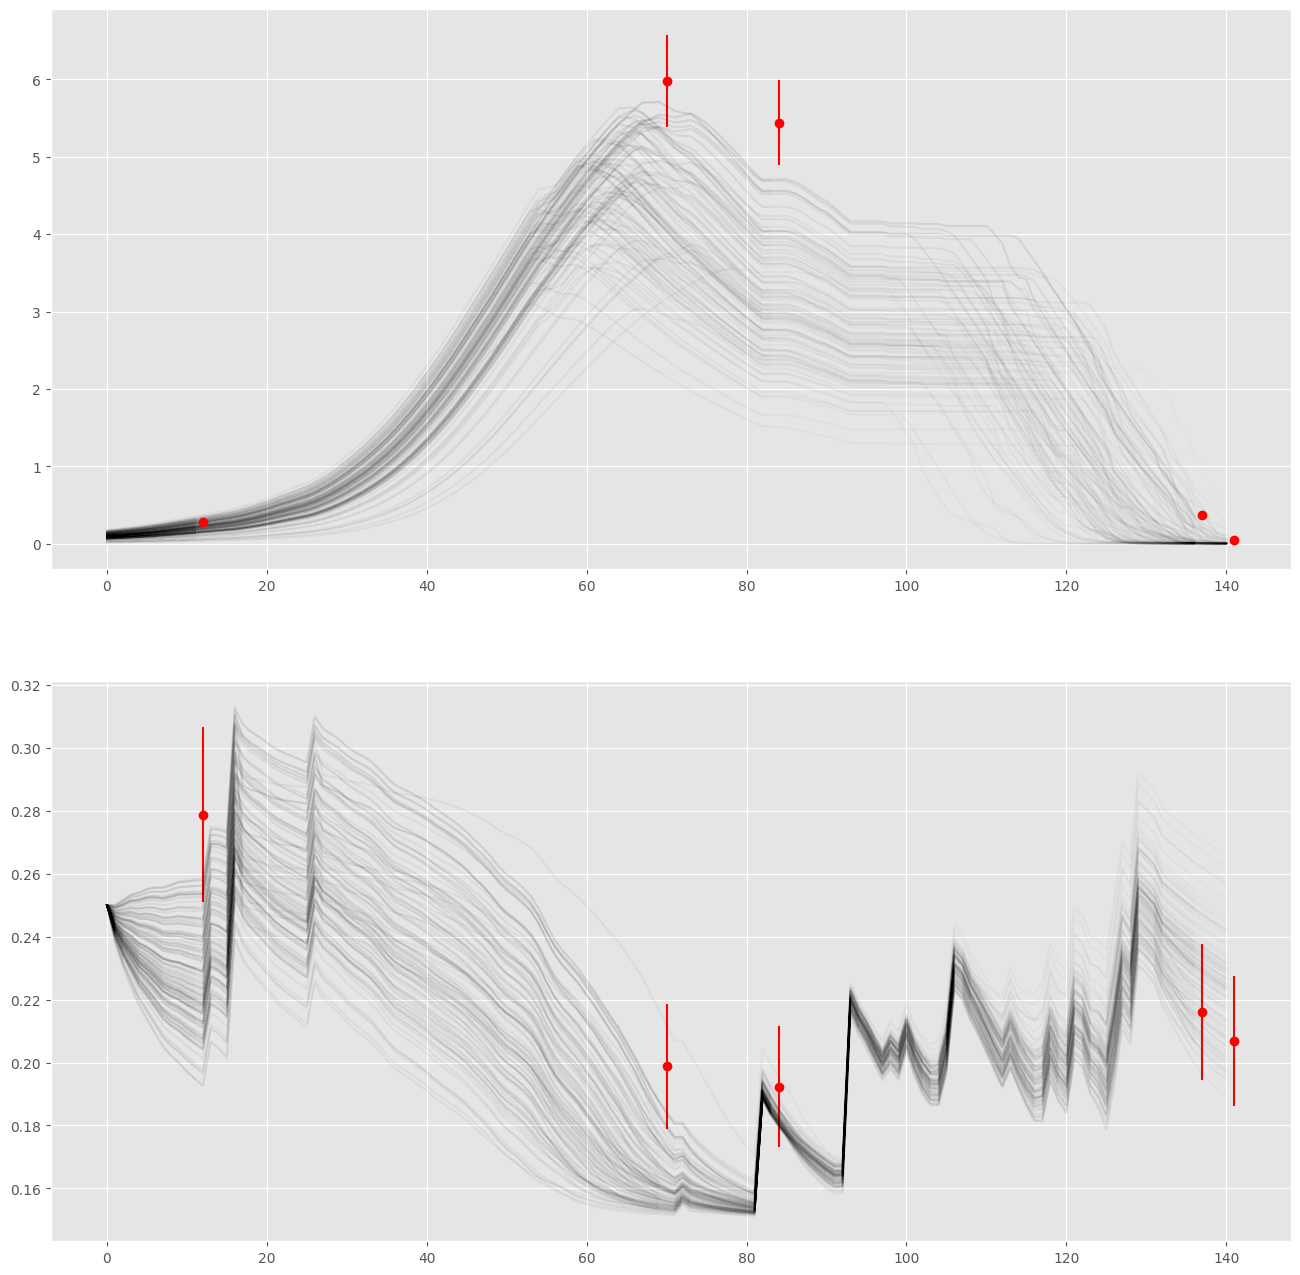

In [4]:

# Appelons maintenant le filtre particulaire
N   = 100
pf  = PfWoFoSt(ensemble_size=N,
              override_parameters=("TDWI","WAV","SPAN","SMFCF"),
              override_ranges=(range1,range2,range3,range4))
start_date = pf.get_current_date()
pf.get_particles_last_value()
pf. batchAssimilate(obs_pack)

On peut représenter l'ensemble des particules afin de voir leur différences

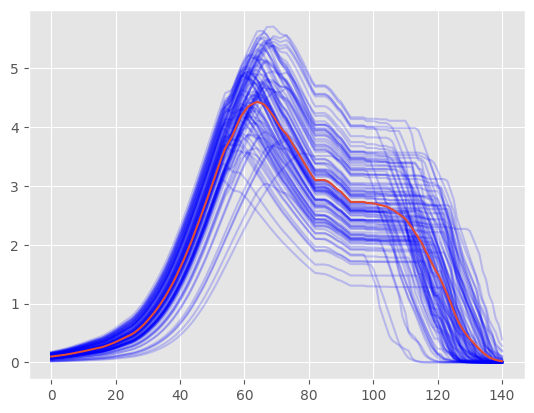

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
sum = pd.DataFrame()
for element in pf.particle_set:
    sum[element] = pd.DataFrame(element.get_output())['LAI']
    plt.plot(pd.DataFrame(element.get_output())['LAI'],alpha=0.2,color='blue')

# courbe moyenne (supposément la vraie valeur)
plt.plot(sum.sum(axis=1)/len(pf.particle_set))


Comparons avec les données observées :

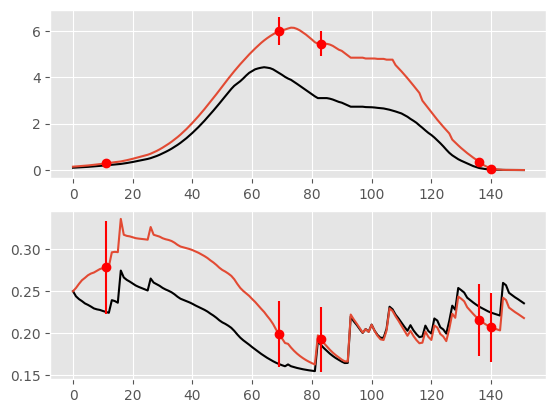

In [6]:
fig, ax = plt.subplots(2,1)
pf.completeSim()
pf.avg(plot=True,obs_list=obs_pack,fig=fig,ax=ax)
ax[0].plot(list(df_reality['LAI']))
ax[1].plot(list(df_reality['SM']))


2000-01-12
0.2870809817505803
2000-03-10
5.980086916295529
2000-03-24
5.44282313456017
2000-05-16
0.36764976611689615
2000-05-20
0.05424743041564401


,LAI
2000-01-12,0.287081
2000-03-10,5.980087
2000-03-24,5.442823
2000-05-16,0.367650
2000-05-20,0.054247


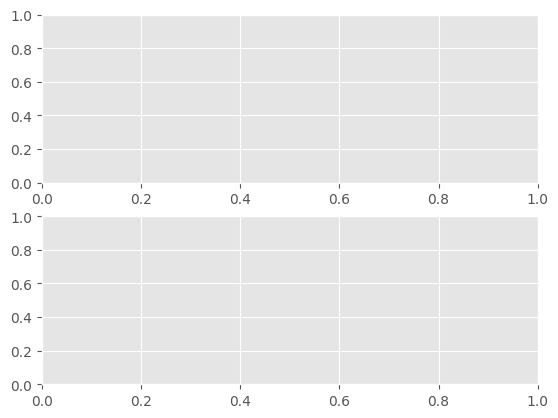

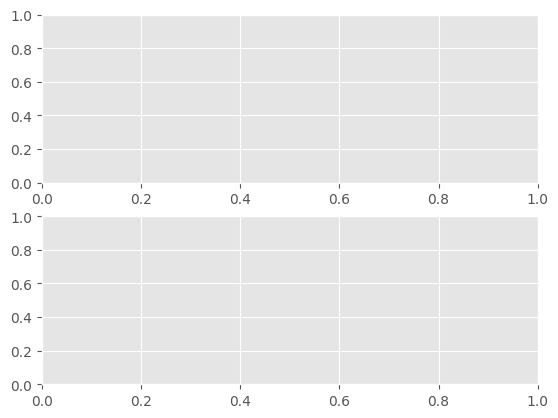

In [27]:
pd.DataFrame(pf.avg()[0])
for element in pf._observations.keys():
    print(element)
    print(pf._observations[element])
def diff(a,b):
            t = 0
            for el in set(a.keys()).intersection(b.keys()):
                t+= (a[el]-b[el])**2
            return np.sqrt(t/len(set(a.keys().intersection(b.keys())))) # RMSE

obs_lai = pd.DataFrame({element:{'LAI':pf._observations[element]} for element in pf._observations.keys()})    
# diff(obs_lai, pd.DataFrame(pf.avg()[0]))
pd.DataFrame(pf.avg()[0])
obs_lai.transpose()
# pd.DataFrame({element:{'LAI':pf._observations[element]['LAI'], 'SM':pf._observations[element]['SM']} for element in pf._observations.keys()})